# Danh sách thành viên

|Họ và tên|MSSV|Công việc|
| :------ | :---: | :--------- |
|Võ Thành Nam|19120301|Cài đặt mạng Neural|
|Lương Ánh Nguyệt|19120315|Phân tích bài toán và dữ liệu|
|Trương Minh Nhật|19120318|Cài đặt mạng Neural|
|Đỗ Lê Khánh Đăng|19120186|Báo cáo kết quả đạt được|

## Chuẩn bị dữ liệu

Import các thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from PIL import Image
from sklearn.model_selection import train_test_split
# %tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


Kết nối đến drive cá nhân

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mở thư mục chứa tập dữ liệu

In [3]:
# cd /content/drive/MyDrive/PlantPathology

In [4]:
# cd /path-to-the-directory-containing-the-dataset

Đọc dữ liệu train và test vào dataframe

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Phân tích bài toán

* **Yêu cầu**: Xây dựng mạng nơron xác định các loại bệnh trên cây thông qua hình ảnh.

* Đây là bài toán image classification, do đó ta sẽ chọn xây dựng **mô hình CNN** để giải quyết bài toán này.

## Phân tích và tiền xử lí dữ liệu

* Tổng số dữ liệu trong tập train là 1821



In [6]:
train_df.shape

(1821, 5)

* Xem 5 dòng đầu tiên của dữ liệu train

In [7]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


Có thể thấy tập dữ liệu được phân loại 4 lớp, gồm: `healthy`, `multiple_diseases`, `rust` và `scab`.

Vì có nhiều hơn 2 lớp, ta sẽ sử dụng Loss function là Cross Entropy và Softmax Function cho Output layer.

* Kiểm tra dữ liệu

Dữ liệu thuộc lớp nào thì lớp đó có giá trị 1, các lớp còn lại có giá trị 0.

In [8]:
(train_df.healthy + train_df.multiple_diseases + train_df.rust + train_df.scab).unique()

array([1], dtype=int64)

Mỗi dữ liệu trong dataset đều thuộc 1 lớp duy nhất, không có dữ liệu nào không có lớp hoặc thuộc nhiều lớp. Như vậy, dữ liệu đã chính xác.

* Xem dữ liệu hình ảnh

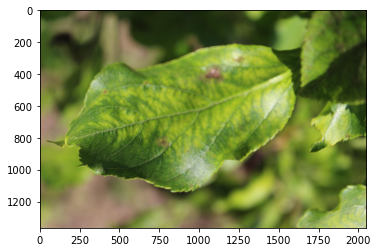

In [9]:
img = Image.open(f'images/{train_df.iloc[0]["image_id"]}.jpg')
plt.imshow(img)

* Thống kê số lượng các lớp trong tập train

In [10]:
count_by_attr = train_df.iloc[:, 1:].sum()

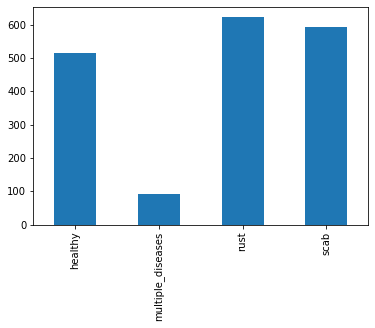

In [11]:
count_by_attr.plot(kind = 'bar');

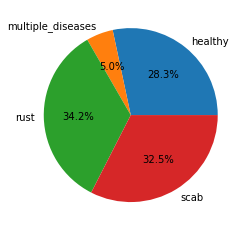

In [12]:
count_by_attr.plot(kind='pie',autopct='%1.1f%%', ylabel='');

Số lượng dữ liệu `multiple_diseases` là rất ít (chưa đến 100 dữ liệu, chỉ chiếm 5%). Trong khi đó, ba lớp còn lại có số lượng dữ liệu khá tương đồng với nhau.

* Xem 4 hình ảnh của mỗi lớp

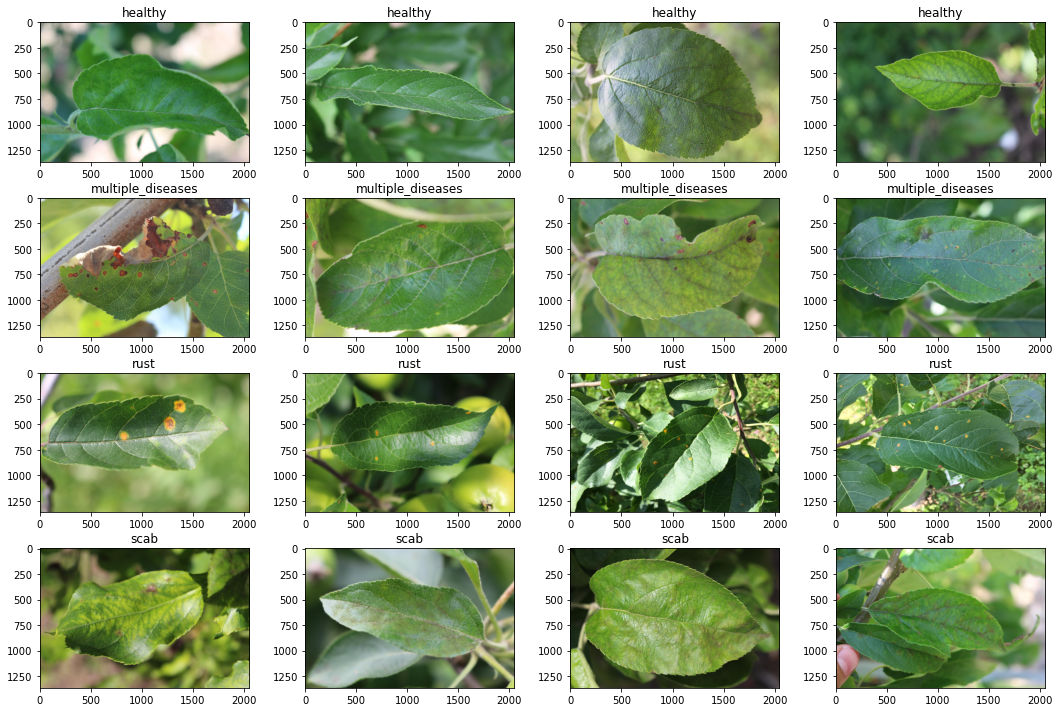

In [13]:
with tf.device('/device:GPU:0'):
    img_to_show = 4
    num_attr = 4
    plt.rcParams['figure.figsize'] = [15,10]
    example_healthy_img = train_df[train_df['healthy']==1].head(img_to_show).reset_index(drop=True)
    example_multi_diseases_img = train_df[train_df['multiple_diseases']==1].head(img_to_show).reset_index(drop=True)
    example_rust_img = train_df[train_df['rust']==1].head(img_to_show).reset_index(drop=True)
    example_scab_img = train_df[train_df['scab']==1].head(img_to_show).reset_index(drop=True)
    example = pd.concat([example_healthy_img,example_multi_diseases_img,example_rust_img,example_scab_img]).reset_index()

    fig, axs = plt.subplots(num_attr, img_to_show)
    for i in range(num_attr):
        for j in range(img_to_show):
            axs[i,j].imshow(mpimg.imread(f'images/{example["image_id"][i*img_to_show+j]}.jpg'))
            axs[i,j].set_title(f'{example.columns[i+2]}')
    fig.tight_layout(h_pad=0.3,w_pad=0.3)

Kích thước hình ảnh

In [14]:
img.size

(2048, 1365)

Hình ảnh có kích thước 2048x1365 là rất lớn. Ta resize kích thước ảnh về 256x256.

Kích thước này vừa giữ lại được những thông tin features quan trọng vừa giúp mô hình không bị overfitting.

* Đặt kích thước mới cho các tấm ảnh

In [15]:
new_img_size = (256,256)

* Gắn nhãn cho dữ liệu trong tập train bằng cách quy định *healthy* = 0, *multiple_diseases* = 1, *rust* = 2, *scab* = 3

In [16]:
train_df['label'] = np.argmax(train_df.iloc[:,1:].values,axis=1)

Một vài dòng đầu tiên của tập dữ liệu train sau khi đã gán nhãn

In [17]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


* Ta chia dữ liệu trong tập train thành 2 tập dữ liệu: train và validate với tỉ lệ là 80% và 20%

In [18]:
train_df,validate_df = train_test_split(train_df,test_size=0.2,random_state=42)

* Đặt lại kích thước và ghép tất cả ảnh trong tập dữ liệu **train** vào 1 mảng duy nhất

In [19]:
with tf.device('/device:GPU:0'):
    img = Image.open(f'images/{train_df.iloc[0]["image_id"]}.jpg')
    img=img.resize(new_img_size)
    images_train = np.array([np.asarray(img)])

    for i in range(1,train_df.shape[0]):
        img = Image.open(f'images/{train_df.iloc[i]["image_id"]}.jpg')
        img = img.resize(new_img_size)
        images_train = np.concatenate((images_train,np.array([np.asarray(img)])),axis=0)

* Đặt lại kích thước và ghép tất cả ảnh trong tập dữ liệu **validate** vào 1 mảng duy nhất

In [20]:
with tf.device('/device:GPU:0'):
    img = Image.open(f'images/{validate_df.iloc[0]["image_id"]}.jpg')
    img=img.resize(new_img_size)
    images_validate = np.array([np.asarray(img)])
    for i in range(1,validate_df.shape[0]):
        img = Image.open(f'images/{validate_df.iloc[i]["image_id"]}.jpg')
        img = img.resize(new_img_size)
        images_validate = np.concatenate((images_validate,np.array([np.asarray(img)])),axis=0)

* Đặt lại kích thước và ghép tất cả ảnh trong tập dữ liệu **test** vào 1 mảng duy nhất

In [21]:
with tf.device('/device:GPU:0'):
    img = Image.open(f'images/{test_df.iloc[0]["image_id"]}.jpg')
    img=img.resize(new_img_size)
    images_test = np.array([np.asarray(img)])
    for i in range(1,test_df.shape[0]):
        img = Image.open(f'images/{test_df.iloc[i]["image_id"]}.jpg')
        img = img.resize(new_img_size)
        images_test = np.concatenate((images_test,np.array([np.asarray(img)])),axis=0)

* Kích thước của các mảng chứa các tập dữ liệu train, validate, test

In [22]:
print("Training set is of shape : ",images_train.shape)
print("Validation set is of shape : ",images_validate.shape)
print("Test set is of shape : ",images_test.shape)

Training set is of shape :  (1456, 256, 256, 3)
Validation set is of shape :  (365, 256, 256, 3)
Test set is of shape :  (1821, 256, 256, 3)


# Xây dựng mô hình CNN

> Ta xây dựng mô hình CNN với kiến trúc như sau:
* Hidden layers: Convolutional layer với hàm kích hoạt ReLU, Pooling layer sử dụng MaxPooling
* Loss function: Cross entropy
* Output layer: Softmax function

* Tăng cường dữ liệu để tăng tính tổng quát của mô hình

In [23]:
with tf.device('/device:GPU:0'):
    data_augmentaion = Sequential([
        layers.RandomRotation(factor=(-0.2,0.2),seed = 123),
        layers.RandomZoom(0.1),
        layers.RandomFlip('horizontal'),
    ])

- Chuyển giá trị các pixel trong ảnh từ 0 - 255 về 0 - 1
- Tăng cường dữ liệu
- Trích xuất đặc trưng bằng nhiều lớp Conv2D, MaxPooling2D
- Trước khi vào dense layer, loại bỏ một số lượng node ngẫu nhiên nhằm tránh khả năng overfitting
- Đưa các đặc trưng vào mạng fully connected với hàm kích hoạt ReLU
- Thu nhỏ số đầu ra của mạng tương ứng với số nhãn của dữ liệu, cho ra vector xác suất với hàm softmax

In [24]:
with tf.device('/device:GPU:0'):
    model = Sequential([
        layers.Rescaling(1./255.,input_shape=(256,256,3)),
        data_augmentaion,
        
        layers.Conv2D(16,(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),   
        
        layers.Conv2D(32,(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),    
        
        layers.Conv2D(64,(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(128,(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(4,activation='softmax'),   
    ])
    model.build()

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)     

- Huấn luyện mô hình với hàm mất mát SparseCategoricalCrossentropy, độ đo Accuracy, tập dữ liệu train và validation

- Huấn luyện mô hình 50 lần, với batch size là 32

In [26]:
with tf.device('/device:GPU:0'):
    model.compile(
        optimizer='adam',
        loss = tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    batch_size = 32
    epochs = 50

    history = model.fit(
        images_train,
        train_df['label'],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(images_validate,validate_df['label']),
    )

Epoch 1/50
46/46 [==============================] - 11s 69ms/step - loss: 2.4238 - accuracy: 0.3716 - val_loss: 6.4534 - val_accuracy: 0.0767
Epoch 2/50
46/46 [==============================] - 2s 45ms/step - loss: 1.2911 - accuracy: 0.4032 - val_loss: 10.6652 - val_accuracy: 0.0904
Epoch 3/50
46/46 [==============================] - 2s 46ms/step - loss: 1.2356 - accuracy: 0.4306 - val_loss: 13.9058 - val_accuracy: 0.0603
Epoch 4/50
46/46 [==============================] - 2s 46ms/step - loss: 1.2118 - accuracy: 0.4416 - val_loss: 12.9137 - val_accuracy: 0.0767
Epoch 5/50
46/46 [==============================] - 2s 45ms/step - loss: 1.1545 - accuracy: 0.4471 - val_loss: 11.9556 - val_accuracy: 0.0877
Epoch 6/50
46/46 [==============================] - 2s 46ms/step - loss: 1.1590 - accuracy: 0.4794 - val_loss: 6.4128 - val_accuracy: 0.1534
Epoch 7/50
46/46 [==============================] - 2s 45ms/step - loss: 1.1007 - accuracy: 0.5110 - val_loss: 10.1066 - val_accuracy: 0.2301
Epoch 8

## Biểu đồ độ chính xác của mô hình sau khi train

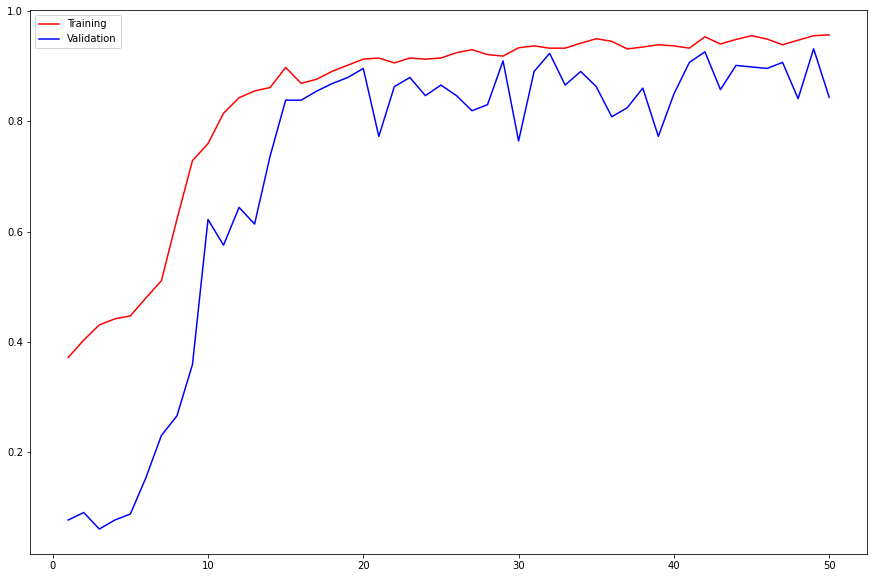

In [27]:
train_acc = history.history['accuracy']
validate_acc = history.history['val_accuracy']
epoch_ = range(1,epochs+1)

plt.plot(epoch_,train_acc,'r',label='Training')
plt.plot(epoch_,validate_acc,'b',label='Validation')
plt.legend()
plt.show()

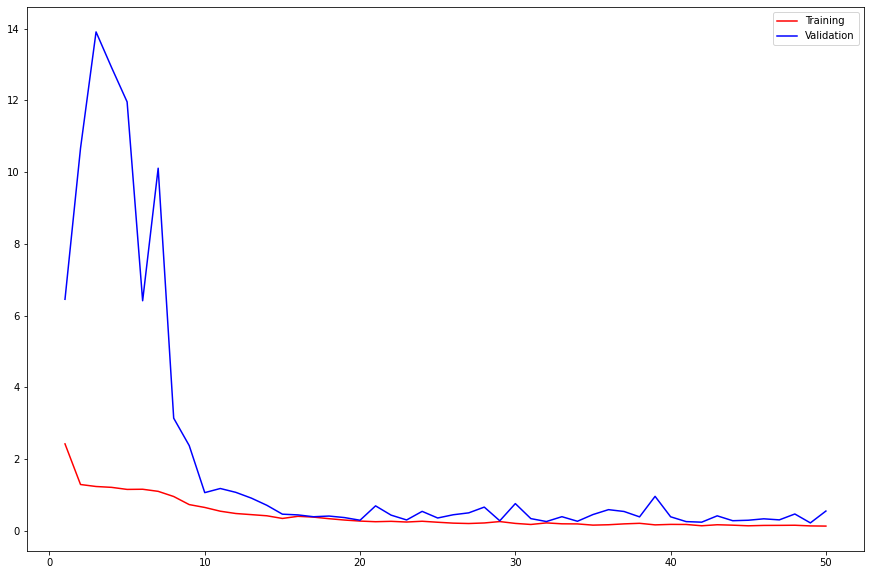

In [28]:
train_loss = history.history['loss']
validate_loss = history.history['val_loss']
epoch_ = range(1,epochs+1)

plt.plot(epoch_,train_loss,'r',label='Training')
plt.plot(epoch_,validate_loss,'b',label='Validation')
plt.legend()
plt.show()

# Báo cáo kết quả đạt được sau khi phân tích và cài


Mô hình đã thực hiện được chức năng đề ra là xác định được bệnh đang có trên cây trồng.<br />
Dựa vào 2 biểu đồ accuracy và loss ở trên, ta thấy được rằng tỷ lệ accuracy của tập train và validation tăng khá nhất quán qua mỗi epoch và đạt khá cao ở epoch cuối cùng. Còn loss thì gần như giảm dần qua mỗi epoch. 



# Sử dụng mô hình để dự đoán trên tập dữ liệu test

In [29]:
with tf.device('/device:GPU:0'):
    predictions = model.predict(images_test)

In [30]:
predictions.shape

(1821, 4)

In [31]:
predictions_df = pd.DataFrame(predictions)
submission_df = pd.concat([test_df,predictions_df],axis=1)

Một vài dòng đầu tiên của dataframe chứa kết quả dự đoán, mỗi dòng tương ứng với một ảnh, thể hiện xác suất dự đoán ứng với mỗi nhãn *healthy*, *multiple_diseases*, *rust*, *scab*

In [32]:
submission_df.head()

,image_id,0,1,2,3
0,Test_0,5.524811e-16,3.628083e-05,9.999638e-01,2.715925e-22
1,Test_1,1.558658e-10,1.002728e-05,9.999900e-01,2.573961e-14
2,Test_2,3.608269e-03,1.385548e-03,1.174575e-07,9.950061e-01
3,Test_3,9.999708e-01,1.719420e-07,1.675945e-05,1.227223e-05
4,Test_4,1.096278e-19,7.020863e-06,9.999930e-01,5.811065e-27


Xuất kết quả dự đoán trên tập dữ liệu test ra tập tin csv

In [33]:
submission_df.columns=train_df.columns.to_list()[:-1]
submission_df.to_csv("submission.csv",index=False)

# Đánh giá phần làm việc của các thành viên trong nhóm

|Họ và tên|MSSV|Đóng góp|
| :------ | :---: | :--------- |
|Võ Thành Nam|19120301|25%|
|Lương Ánh Nguyệt|19120315|25%|
|Trương Minh Nhật|19120318|25%|
|Đỗ Lê Khánh Đăng|19120186|25%|

***Tự đánh giá:***
- Võ Thành Nam: Hoàn thành các phần việc được giao. Mô hình đưa ra kết quả tương đối tốt trên tập dữ liệu được cung cấp. Tuy nhiên nhóm chỉ mới đưa ra được một mô hình mạng 
- Trương Minh Nhật: Hoàn thành tốt phần việc được giao
- Lương Ánh Nguyệt: Hoàn thành tốt phần việc được giao
- Đỗ Lê Khánh Đăng:Hoàn thành tốt việc được giao

# Tài liệu tham khảo

- https://youtube.com/playlist?list=PLMm4sOMuA2QI5x_0KlNT3LuKDi6-ByboB
- https://cs231n.github.io/convolutional-networks/